# Проверка гипотез по увеличению выручки в интернет-магазине — оценка результатов A/B теста

## Описание задачи

Используя данные интернет-магазина приоритезировать гипотезы, произвести оценку результатов A/B-тестирования различными методами.

## Описание данных

Таблица hypothesis:
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Таблица orders:
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Таблица visits:
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## План работы

- Часть 1. Приоритизация гипотез.
- Часть 2. Анализ A/B-теста.

## Часть 1. Приоритизация гипотез.

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
# Ознакомимся с оценками Reach, Impact, Confidence, Efforts рассматриваемых гипотез
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [3]:
# Приоритизируем гипотезы по фреймворку ICE 
hypothesis['ice'] = (hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).round(2)
hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False).head()

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день...",16.20
0,"Добавить два новых канала привлечения трафика,...",13.33
7,Добавить форму подписки на все основные страни...,11.20
6,Показать на главной странице баннеры с актуаль...,8.00
2,Добавить блоки рекомендаций товаров на сайт ин...,7.00


In [4]:
# Приоритизируем гипотезы по фреймворку RICE 
hypothesis['rice'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).round(2)
hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False).head()

,hypothesis,rice
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2


## Выводы

Если при применении фреймворка ICE на первом месте гипотеза №8, то при применении фреймворка RICE на первом месте гипотеза №7. Это связано с тем, что значение охвата пользователей (reach) гипотезы №7 самое большое среди всех гипотез. Однако первые пять гипотез остались неизменны 0, 2, 6, 7, 8 при применении обоих фреймворков.

## Часть 2. Анализ A/B-теста

In [5]:
orders = pd.read_csv('/datasets/orders.csv')
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [6]:
visits = pd.read_csv('/datasets/visitors.csv')
visits

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


### 1. Построим график кумулятивной выручки по группам

In [7]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()
datesGroups

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A
...,...,...
1068,2019-08-12,A
1114,2019-08-13,B
1116,2019-08-13,A
1149,2019-08-14,B


In [8]:
# Найдем кумулятивную сумму выручки, а также посчитаем кол-во ункальных заказо и пользоватлей на каждую дату
ordersAggregated = (datesGroups
                              .apply(lambda x:
                                    orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
                              .agg({'date' : 'max',
                                    'group' : 'max',
                                    'transactionId' : 'nunique',
                                    'visitorId' : 'nunique',
                                    'revenue' : 'sum'}), axis=1)
                              .sort_values(by=['date','group'])
                   )
ordersAggregated

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874
...,...,...,...,...,...
496,2019-08-29,B,596,544,5559398
730,2019-08-30,A,545,493,4022970
690,2019-08-30,B,620,567,5774631
958,2019-08-31,A,557,503,4084803


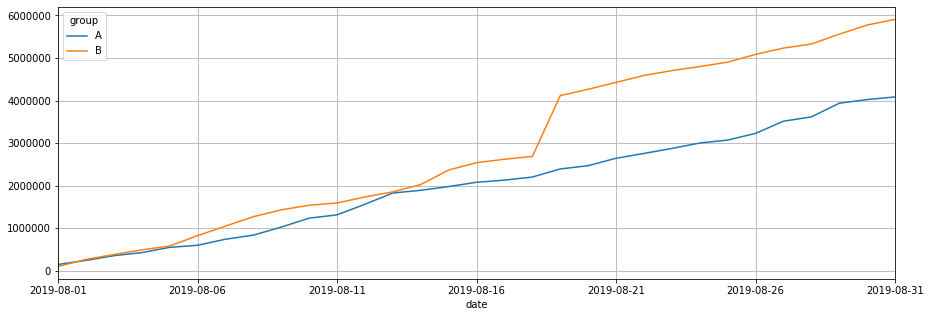

In [9]:
# Построим график кумулятивной суммы по группе А и В 
ordersAggregated.pivot_table(index='date', values='revenue', columns='group').plot(figsize=(15, 5), grid=True)
plt.show()

### Вывод

Кумулятивная выручка примерно равная в обоих группах до 5 августа, после этого группа В вырывается вперед и оставется в лидерах до конца теста. При этом в районе 18-19 августа наблудается сильный скачек вверх кумулятивной выручки группы В.

### 2. Построим график кумулятивного среднего чека по группам

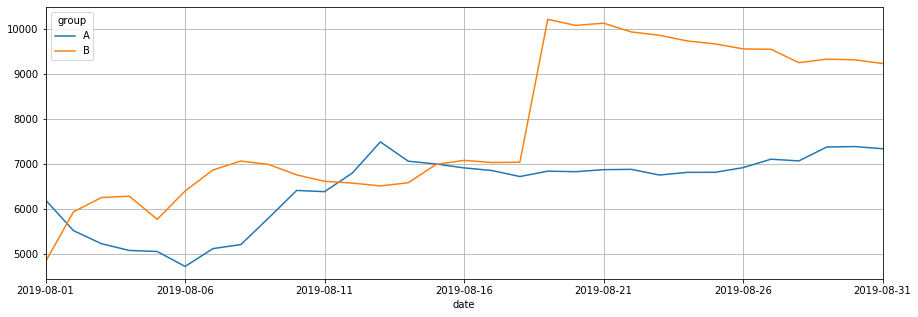

In [10]:
# Разделим кумулятивную выручку на кумулятивное число заказов, чтобы найти кумулятивное значение среднего чека по группам
ordersAggregated['average_check'] = (ordersAggregated['revenue'] / ordersAggregated['transactionId']).round(2)
average_check_A_B = ordersAggregated.pivot_table(index='date', values='average_check', columns='group')
average_check_A_B.plot(figsize=(15, 5), grid=True)
plt.show()

### Вывод

Средний чек для группы А устанавливается в середине теста, для группы В ближе к концу. Также наблюдается сильный всплеск в районе 18-19 августа, возможно в эти даты имели место быть крупные заказы.

### 3. Построим график относительного изменения кумулятивного среднего чека группы B к группе A

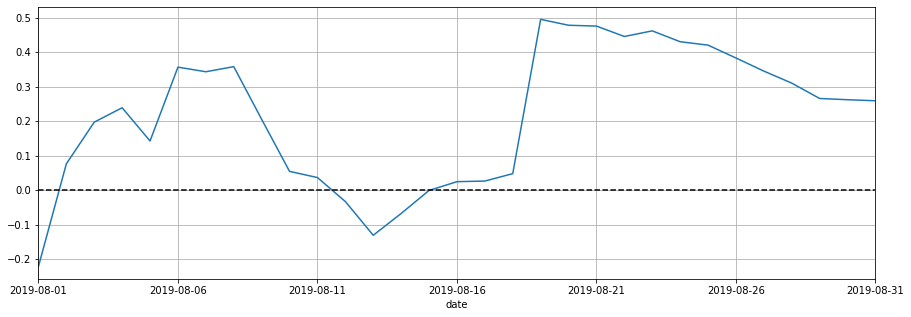

In [11]:
# Найдем относительное значение между кумулятивными значениями чека группы В и А
average_check_A_B['relative_difference'] = average_check_A_B['B'] / average_check_A_B['A'] - 1
average_check_A_B['relative_difference'].plot(figsize=(15, 5), grid=True)
# Проведем горизонтальную ось 
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

### Вывод

График скачет, что подтверждает наличие выбросов в заказах.

### 4. Построим график кумулятивной конверсии по группам

In [12]:
# Посчитаем кол-во ункальных посетителей на каждую дату и группу
visitorsAggregated = (datesGroups
                                .apply(lambda x:
                                       visits[np.logical_and(visits['date'] <= x['date'], visits['group'] == x['group'])]
                                .agg({'date' : 'max',
                                      'group' : 'max',
                                      'visitors' : 'sum'}), axis=1)
                                .sort_values(by=['date','group'])
                     )
# Соединим таблици заказов и посетителей
cumm_data = ordersAggregated.merge(visitorsAggregated, on=['date', 'group'])
cumm_data

,date,group,transactionId,visitorId,revenue,average_check,visitors
0,2019-08-01,A,24,20,148579,6190.79,719
1,2019-08-01,B,21,20,101217,4819.86,713
2,2019-08-02,A,44,38,242401,5509.11,1338
3,2019-08-02,B,45,43,266748,5927.73,1294
4,2019-08-03,A,68,62,354874,5218.74,1845
...,...,...,...,...,...,...,...
57,2019-08-29,B,596,544,5559398,9327.85,17708
58,2019-08-30,A,545,493,4022970,7381.60,18037
59,2019-08-30,B,620,567,5774631,9313.92,18198
60,2019-08-31,A,557,503,4084803,7333.58,18736


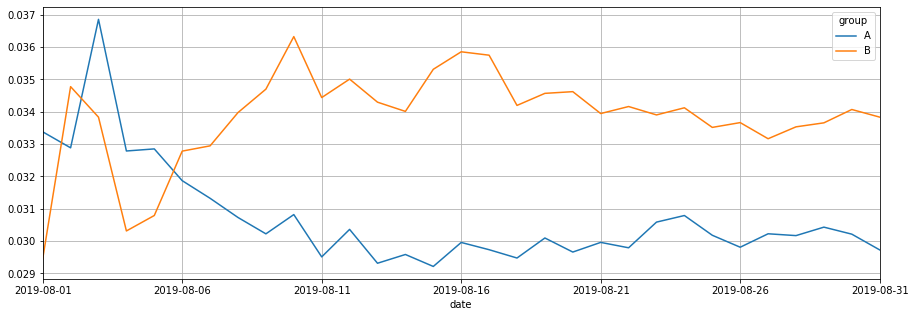

In [13]:
# Найдем кумулятивную конверсию
cumm_data['conversion'] = cumm_data['transactionId'] / cumm_data['visitors']
# Построим график
conversion_A_B = cumm_data.pivot_table(index='date', values='conversion', columns='group')
conversion_A_B.plot(figsize=(15, 5), grid=True)
plt.show()

### Вывод

В начале теста группа А имела большую конверсию, но после 6 августа группа В вырвалась вперед и стабилизировалась возле одного значения больше, чем у группы А.

### 5. Построим график относительного изменения кумулятивной конверсии группы B к группе A

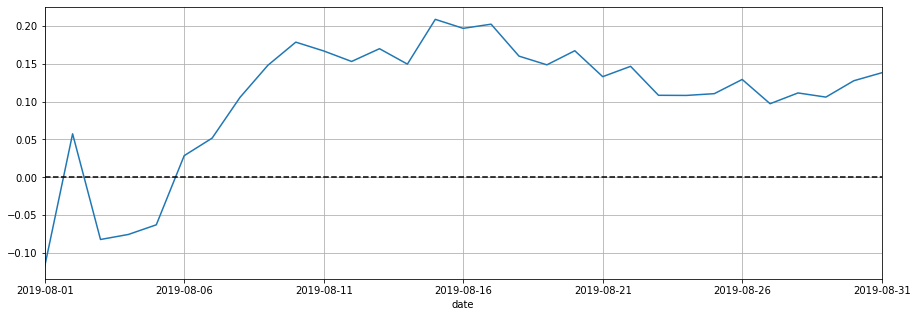

In [14]:
# Найдем относительное значение между кумулятивными значениями конверсии В и А
conversion_A_B['relative_difference'] = conversion_A_B['B'] / conversion_A_B['A'] - 1
conversion_A_B['relative_difference'].plot(figsize=(15, 5), grid=True)
# Проведем горизонтальную ось 
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

### Вывод

В начале теста конверсия группы В уступала конверсии группы А, но после 6 августа и до конца теста она стабильно выше на 10-20%. 

### 6. Построим точечный график количества заказов по пользователям

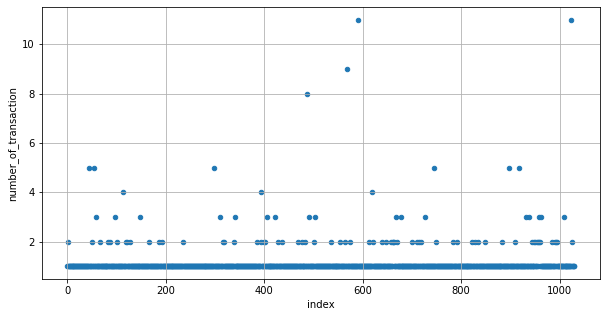

In [15]:
# Посчитаем сколько заказов сделал каждый пользователь
ordersByUsers = orders.groupby('visitorId', as_index=False).agg({'transactionId' : 'nunique'})
ordersByUsers.columns = ['visitorId','number_of_transaction']
ordersByUsers.reset_index().plot(kind='scatter', x='index', y='number_of_transaction', figsize=(10, 5), grid=True)
plt.show()

### Вывод

Основная масса пользователей сделало только 1 заказ. Есть пользователи, которые сделали более 10 заказов.

### 7. Посчитаем 95-й и 99-й перцентили количества заказов на пользователя

array([2., 4.])

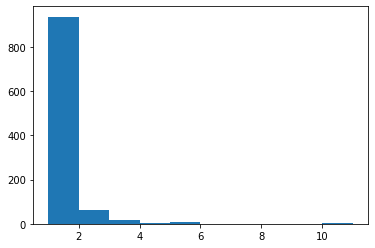

In [16]:
# Построим гистограмму и определим 95 и 99 перцентили
plt.hist(ordersByUsers['number_of_transaction'])
np.percentile(ordersByUsers['number_of_transaction'], [95, 99])

### Вывод

Не более 5% пользователей сделали более 2 и более транзакций, 1% пользователей заказывали 4 и более раз. Примем за граничное значение кол-во заказов на одного пользователя - 4 заказа.

### 8. Построим точечный график стоимостей заказов

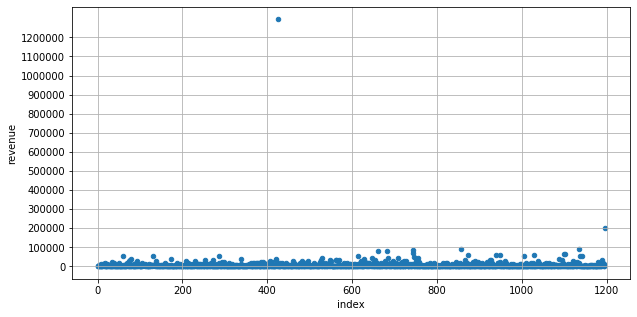

In [17]:
orders.reset_index().plot(kind='scatter', x='index', y='revenue', figsize=(10, 5), grid=True)
plt.yticks(np.arange(0,1300000, 100000))
plt.show()

### Вывод

Основная масса заказов находится в пределах 100 000. Выбросов не много, но есть один большой заказ более 1 200 000, который явно влияет на корректность результатов.

### 9. Посчитаем 95-й и 99-й перцентили стоимости заказов

array([28000. , 58233.2])

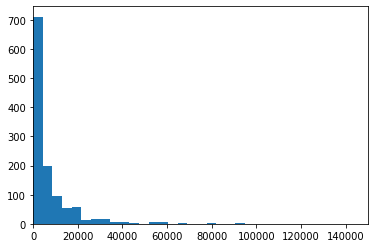

In [18]:
# Построим гистограмму и определим 95 и 99 перцентили
plt.xlim(0, 150000)
plt.hist(orders['revenue'], bins=300)
np.percentile(orders['revenue'], [95, 99])

### Вывод

Заказов дороже 28 000 не более 5%, заказов дороже 58 233.2 не более 1%. Примем за граничное значение стоимости заказа - заказы не дороже 58 000.

### 10. Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным

In [19]:
# Сгруппируем для каждой группы таблицы по пользователям и кол-ву их заказов
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : 'nunique'})
ordersByUsersA.columns = ['visitorId', 'transactions']
ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : 'nunique'})
ordersByUsersB.columns = ['visitorId', 'transactions']

# Подготовим две выборки  для статистического теста Манна-Уитни
sampleA = pd.concat([ordersByUsersA['transactions'],pd.Series(0, index=np.arange(visits.loc[visits['group'] == 'A', 'visitors']
            .sum() - len(ordersByUsersA['transactions'])), name='transactions')],axis=0)
sampleB = pd.concat([ordersByUsersB['transactions'],pd.Series(0, index=np.arange(visits.loc[visits['group'] == 'B', 'visitors']
            .sum() - len(ordersByUsersB['transactions'])), name='transactions')],axis=0)

# Проведем тест
alpha = .05
results = stats.mannwhitneyu(sampleA, sampleB)

print('p-значение: ', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: различия в конверсиях статистически значимы")
else:
    print("Не получилось отвергнуть нулевую гипотезу: вывод о различии сделать нельзя")
print('Относительная разница между конверсиями: {:.0%}'.format(sampleB.mean() / sampleA.mean() - 1))

p-значение:  0.008396177528376304
Отвергаем нулевую гипотезу: различия в конверсиях статистически значимы
Относительная разница между конверсиями: 14%


### Вывод

Различия в конверсиях статистически значимы, значит мы вполне можем допустить, что эти различия не случайны, причем в пользу группы В, которая на 14% выйгрывает в относительной конверсии у группы А.

### 11. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

In [20]:
# Проведем тест
alpha = .05
results = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])

print('p-значение: ', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: различия в конверсиях статистически значимы")
else:
    print("Не получилось отвергнуть нулевую гипотезу: вывод о различии сделать нельзя")
print('Относительная разница между конверсиями: {:.0%}'
      .format(orders[orders['group']=='B']['revenue'].mean() / orders[orders['group']=='A']['revenue'].mean() - 1))

p-значение:  0.3646454927716229
Не получилось отвергнуть нулевую гипотезу: вывод о различии сделать нельзя
Относительная разница между конверсиями: 26%


### Вывод

Статистический тест по различиям в среднем чеке говорит о том, что выводы о различии выборок делать нельзя. Относительная разница между чеками группы В и А составляет 26%.

### 12. Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным

In [21]:
# Узнаем номера аномальных пользователей
usersWithManyOrders = ordersByUsers[ordersByUsers['number_of_transaction'] > 4]['visitorId']
usersWithExpensiveOrders = orders[orders['revenue'] > 58000]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
abnormalUsers.shape

(21,)

In [22]:
# Отфильтруем выборки от аномальных пользователей
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorId']
                    .isin(abnormalUsers))]['transactions'],pd.Series(0, index=np.arange(visits
                    .loc[visits['group'] == 'A', 'visitors']
                    .sum() - len(ordersByUsersA['transactions'])),name='transactions')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorId']
                    .isin(abnormalUsers))]['transactions'],pd.Series(0, index=np.arange(visits
                    .loc[visits['group'] == 'B', 'visitors']
                    .sum() - len(ordersByUsersB['transactions'])),name='transactions')],axis=0)
# Проведем тест
alpha = .05
results = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)

print('p-значение: ', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: различия в конверсиях статистически значимы")
else:
    print("Не получилось отвергнуть нулевую гипотезу: вывод о различии сделать нельзя")
print('Относительная разница между конверсиями: {:.0%}'.format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

p-значение:  0.006899620351026831
Отвергаем нулевую гипотезу: различия в конверсиях статистически значимы
Относительная разница между конверсиями: 15%


### Вывод

Различия в конверсиях "очищенных данный" также статистически значимы, значит выбросы не сильно влияют на конверсию.

### 13. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [23]:
# Проведем тест
alpha = .05
results = stats.mannwhitneyu(orders[np.logical_and(orders['group']=='A', np.logical_not(orders['visitorId']
                                      .isin(abnormalUsers)))]['revenue'],
                             orders[np.logical_and(orders['group']=='B', np.logical_not(orders['visitorId']
                                      .isin(abnormalUsers)))]['revenue'])

print('p-значение: ', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: различия в конверсиях статистически значимы")
else:
    print("Не получилось отвергнуть нулевую гипотезу: вывод о различии сделать нельзя")
print('Относительная разница между конверсиями: {:.0%}'
      .format(orders[np.logical_and(orders['group']=='A', np.logical_not(orders['visitorId']
                                      .isin(abnormalUsers)))]['revenue']
                                      .mean() / 
                                    orders[np.logical_and(orders['group']=='B', np.logical_not(orders['visitorId']
                                      .isin(abnormalUsers)))]['revenue']
                                      .mean() - 1))

p-значение:  0.4787629773071914
Не получилось отвергнуть нулевую гипотезу: вывод о различии сделать нельзя
Относительная разница между конверсиями: 1%


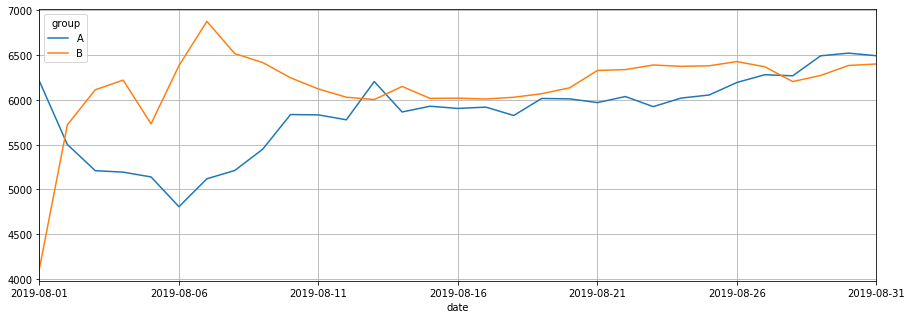

In [24]:
# Построим график кумулятивного среднего чека по группам после очистки данных
orders_filtred = orders[np.logical_not(orders['visitorId'].isin(abnormalUsers))]
ordersAggregated_filterd = (datesGroups
                              .apply(lambda x:
                                    orders_filtred[np.logical_and(orders_filtred['date'] <= x['date'], orders_filtred['group'] == x['group'])]
                              .agg({'date' : 'max',
                                    'group' : 'max',
                                    'transactionId' : 'nunique',
                                    'visitorId' : 'nunique',
                                    'revenue' : 'sum'}), axis=1)
                              .sort_values(by=['date','group'])
                   )
ordersAggregated_filterd['average_check'] = ((ordersAggregated_filterd['revenue'] / ordersAggregated_filterd['transactionId'])
                                            .round(2))
average_check_A_B_filtred = ordersAggregated_filterd.pivot_table(index='date', values='average_check', columns='group')
average_check_A_B_filtred.plot(figsize=(15, 5), grid=True)
plt.show()

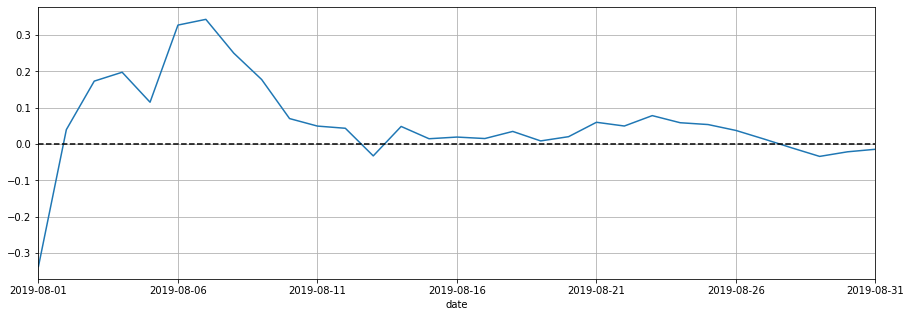

In [25]:
# Найдем относительное значение между кумулятивными значениями чека группы В и А после очистки
average_check_A_B_filtred['relative_difference'] = average_check_A_B_filtred['B'] / average_check_A_B_filtred['A'] - 1
average_check_A_B_filtred['relative_difference'].plot(figsize=(15, 5), grid=True)
# Проведем горизонтальную ось 
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

### Вывод

Статистический тест по различиям в среднем чеке на "очищенных данных" говорит о том, что выводы о различии выборок также делать нельзя. Относительная разница между чеками группы В и А составляет всего 1%, что также подтверждают графики. Выбросы оказывали сильное влияние на относительную разницу между средними чеками.

### 14. Решение по результатам теста

1. Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.
2. Относительное различие в конверсиях по "очищенным" данным составляет 15% в пользу группы В.
3. И по "сырым", и по "очищенным" данным нет статистически значимого различия по среднему чеку между группами.
4. Выброси оказывают сильное влияние на средний чек, если до выбросов относительное различие составляло 26% в пользу группы В, то после очистки от выбросов влияние практически нивелировалось и составило 1%.

Исходя из вышеизложенного можно остановть тест и сделать вывод о его частичном успехе. Группа В статистически значимо лучше группы А по конверсии. Не смотря на превосходство по графику группы В над группой А по куммулятивному среднему чеку, на эту метрику сильное влияние оказвают выбросы, да и статистически значимого различия в среднем чеке нет.